In [1]:
import os

import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from src.models_3d.tf_data import get_tf_data
from src.data_augmentation.augmentation import Standardization, GaussianBlur, RightAngleRotation
from src.data.utils import get_lung_volume, get_split


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def configure_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus),
                      "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

configure_gpu()

1 Physical GPUs, 1 Logical GPUs


2022-05-04 16:35:21.420305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 16:35:22.112621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21443 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
clinical_df = pd.read_csv("../data/clinical_info_with_lung_info.csv").set_index("patient_id")

In [4]:
file = h5py.File(
    "../data/processed/data.hdf5",
    "r")

In [5]:
patient_list = list(file.keys())
patient_list.remove("PatientLC_63")  # Just one lung
patient_list.remove("PatientLC_72")  # the same as 70

In [6]:
ids_train, ids_val, ids_test = get_split(0)

In [7]:
np.sum(clinical_df.loc[ids_train, "plc_status"].values)

37

In [8]:
len(ids_train)

50

In [9]:
np.sum(clinical_df.loc[ids_train, "plc_status"].values)

37

In [10]:
preprocessor = Standardization()
augmenter = RightAngleRotation(p=1.0)
blurrer = GaussianBlur(p=1.0)

def f(im, mask, pstatus, patient_id):
    im = preprocessor(im)
    im, mask = augmenter(im, mask)
    im = blurrer(im)
    return im, mask, pstatus, patient_id

In [19]:
ds_train = get_tf_data(
    file,
    clinical_df,
    patient_list=ids_train,
    shuffle=True,
    oversample=False,
    center_on="GTVl",
    random_center=True,
    return_gtvl=True,
).map(f).batch(4)


In [20]:
images, masks, pstatus, patient_id = next(ds_train.as_numpy_iterator())

In [21]:
def find_middle_slice(mask):
    positions = np.where(mask == 1)

    return (np.max(positions[2]) + np.min(positions[2])) // 2


Patient: b'PatientLC_73' Slice: 60, and plc_status: 1.0


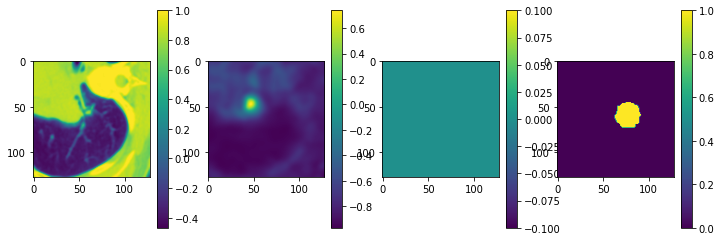

In [23]:
b = 0
s = find_middle_slice(masks[b, :, :, :, 1])
print(f"Patient: {patient_id[b]} Slice: {s}, and plc_status: {pstatus[b]}")
plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(images[b, :, :, s, 0])
plt.colorbar()
plt.subplot(142)
plt.imshow(images[b, :, :, s, 1])
plt.colorbar()
plt.subplot(143)
plt.imshow(masks[b, :, :, s, 0])
plt.colorbar()
plt.subplot(144)
plt.imshow(masks[b, :, :, s, 1])
plt.colorbar()

In [ ]:
patient_id[0]